In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.ticker as mticker
from torchdiffeq import odeint

In [ ]:
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']
)

swap_rates = data.iloc[:, -8:] 
currencies = data["Currency"] 
dates = data["Date"] 

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency] 
    currency_dates = dates[currencies == currency]  
    currency_labels = currencies[currencies == currency] 

    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        
        self.encoder = nn.Linear(8, latent_dim, bias=False)

        self.H_hidden = nn.Linear(latent_dim, latent_dim, bias=False) 
        self.H_activation = CenteredSoftmax() 
        self.H_output = nn.Linear(latent_dim, latent_dim, bias=False)  

        self.G_hidden = nn.Linear(latent_dim, latent_dim + 1, bias=False) 
        self.G_activation = CenteredSoftmax()  
        self.G_output = nn.Linear(latent_dim + 1, latent_dim + 1, bias=False)  

        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]

        z = self.encoder(x)

        z_repeated = z.unsqueeze(1).repeat(1, 31, 1)
        z_repeated.requires_grad_(True)

        maturities = torch.linspace(0, 30, steps=31, dtype=torch.float32, device=x.device).unsqueeze(0).expand(batch_size, -1)
        maturities = maturities.clone().detach().requires_grad_(True)  

        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)

        hidden = self.activation(self.decoder_hidden(decoder_input))
        zero_coupon_rates = self.decoder_output(hidden).squeeze(-1)

        H_hidden_out = self.H_activation(self.H_hidden(z_repeated)) 
        mu = self.H_output(H_hidden_out)  

        G_hidden_out = self.G_activation(self.G_hidden(z_repeated)) 
        G_out = self.G_output(G_hidden_out)

        sigma1 = torch.exp(G_out[:, :, 0])  
        sigma2 = torch.exp(G_out[:, :, 1]) 
        rho1 = torch.tanh(G_out[:, :, 2])  

        sigma_matrix = torch.zeros(batch_size, 31, 2, 2, device=x.device) 
        sigma_matrix[:, :, 0, 0] = sigma1 
        sigma_matrix[:, :, 1, 0] = rho1 * sigma2 
        sigma_matrix[:, :, 1, 1] = sigma2 * torch.sqrt(1 - rho1 ** 2)

        risk_neutral_rate = zero_coupon_rates[:, 0].unsqueeze(1).repeat(1, 31)

        discount_factors = torch.exp(-zero_coupon_rates * maturities)

        gradients_maturities = torch.autograd.grad(
            outputs=discount_factors,
            inputs=maturities,
            grad_outputs=torch.ones_like(discount_factors),
            create_graph=True
        )[0]

        gradients_latent = torch.autograd.grad(
            outputs=discount_factors, 
            inputs=z_repeated,          
            grad_outputs=torch.ones_like(discount_factors), 
            create_graph=True 
        )[0]

        hessian_list = []
        for i in range(latent_dim):  
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,  
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1))  

        hessian = torch.cat(hessian_list, dim=-1)

        return zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors

def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    zero_coupon_rates = zero_coupon_rates[:, 1:] 
    maturities = torch.arange(1, 31, dtype=torch.float32, device=zero_coupon_rates.device).unsqueeze(0)

    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums

    return swap_rates

def finance_informed_loss(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):

    term_1 = (-r_t * discount_factors)

    term_2 = gradients_maturities

    term_3 = torch.sum(gradients_latent * mu, dim=2)

    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),              
        torch.matmul(hessian, sigma_matrix)     
    )  

    trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]  

    term_4 = 0.5 * trace_sigma_H_sigma

    terms = term_1 - term_2 + term_3 + term_4

    arbitrage_loss = torch.mean((terms) ** 2)

    return arbitrage_loss, terms

# Set fixed parameters
initial_learning_rate = 0.01  
batch_size = 32
latent_dim = 2
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50) 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []
train_arbitrage = []
val_arbitrage = []

best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_train = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch) + arbitrage_loss
        loss.backward()
        optimizer.step()
        total_train_loss += mse_train.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5  
    train_losses.append(avg_train_loss)
    avg_train_arbitrage = torch.mean(abs(terms))
    train_arbitrage.append(avg_train_arbitrage)
    
    # Validation
    model.eval()
    total_val_loss = 0
    for X_batch in val_loader:
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_val = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        val_loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch) + arbitrage_loss
        total_val_loss += mse_val.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5  
    val_losses.append(avg_val_loss)
    avg_val_arbitrage = torch.mean(abs(terms))
    val_arbitrage.append(avg_val_arbitrage)
    
    # Update learning rate scheduler
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

#model.load_state_dict(best_model_state)  
#torch.save(best_model_state, "best_fiae2_model.pt") 

Epoch 0, Train RMSE: 0.019817, Val RMSE: 0.012889, LR: 0.010000


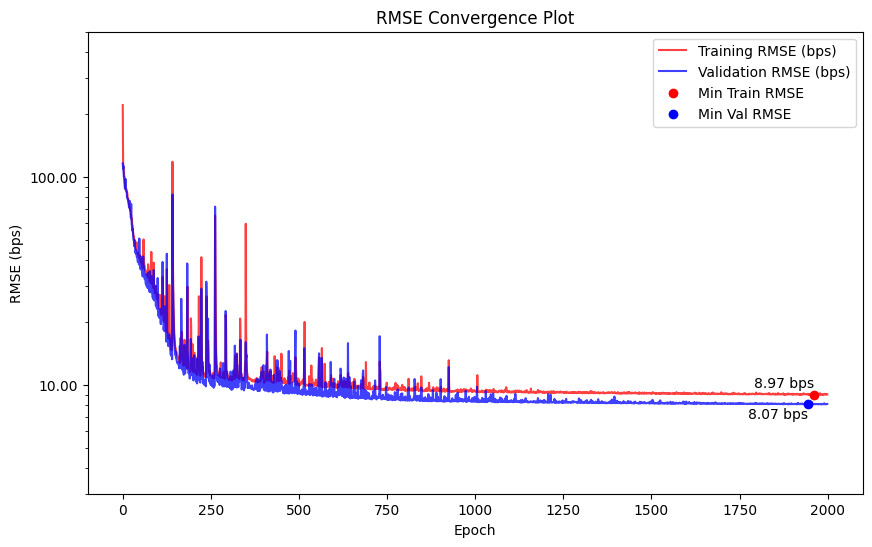

In [ ]:
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 0.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 1.4, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')
plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log') 
plt.ylim(3, 500)
plt.yticks([10, 100])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.legend()
plt.show()

In [ ]:
#model.load_state_dict(torch.load("best_fiae2_model.pt"))

model.eval()

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

def finance_informed_loss_abs(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):
    term_1 = (-r_t * discount_factors)

    term_2 = gradients_maturities

    term_3 = torch.sum(gradients_latent * mu, dim=2)

    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),               
        torch.matmul(hessian, sigma_matrix)       
    )  

    trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1] 

    term_4 = (1 / 2) * trace_sigma_H_sigma

    arbitrage_loss = torch.mean(abs(term_1 - term_2 + term_3 + term_4))

    return arbitrage_loss

def compute_metrics(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)

    mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
    rmse = mse_loss.sqrt().item() * 10_000  

    arbitrage_loss = finance_informed_loss_abs(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
    abs_arbitrage = arbitrage_loss.item() * 10_000 

    return rmse, abs_arbitrage

currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_arbitrage = compute_metrics(model, currency_train_tensor)
    val_rmse, val_arbitrage = compute_metrics(model, currency_val_tensor)
    test_rmse, test_arbitrage = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse,
        "Train Absolute Arbitrage Loss": train_arbitrage,
        "Validation Absolute Arbitrage Loss": val_arbitrage,
        "Test Absolute Arbitrage Loss": test_arbitrage
    })

rmse_df = pd.DataFrame(currency_metrics)

average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()
average_train_arbitrage_loss = rmse_df["Train Absolute Arbitrage Loss"].mean()
average_val_arbitrage_loss = rmse_df["Validation Absolute Arbitrage Loss"].mean()

rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Train Absolute Arbitrage Loss"].mean(),
    rmse_df["Validation Absolute Arbitrage Loss"].mean(),
    rmse_df["Test Absolute Arbitrage Loss"].mean()
]

print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)  Train Absolute Arbitrage Loss  Validation Absolute Arbitrage Loss  Test Absolute Arbitrage Loss
     AUD          9.652675               9.723666        15.692995                       1.249703                            1.181238                      1.016828
     CAD          9.918862               8.605108        33.457370                       1.367084                            1.090243                      2.675891
     DKK          8.364191               5.526506        17.968949                       1.694326                            1.572596                      2.097567
     EUR          8.579477               6.975023        18.935786                       1.742293                            2.059318                      2.198574
     GBP          8.813349               9.526981              NaN                       1.654759                            1.853767                           NaN
     JPY        

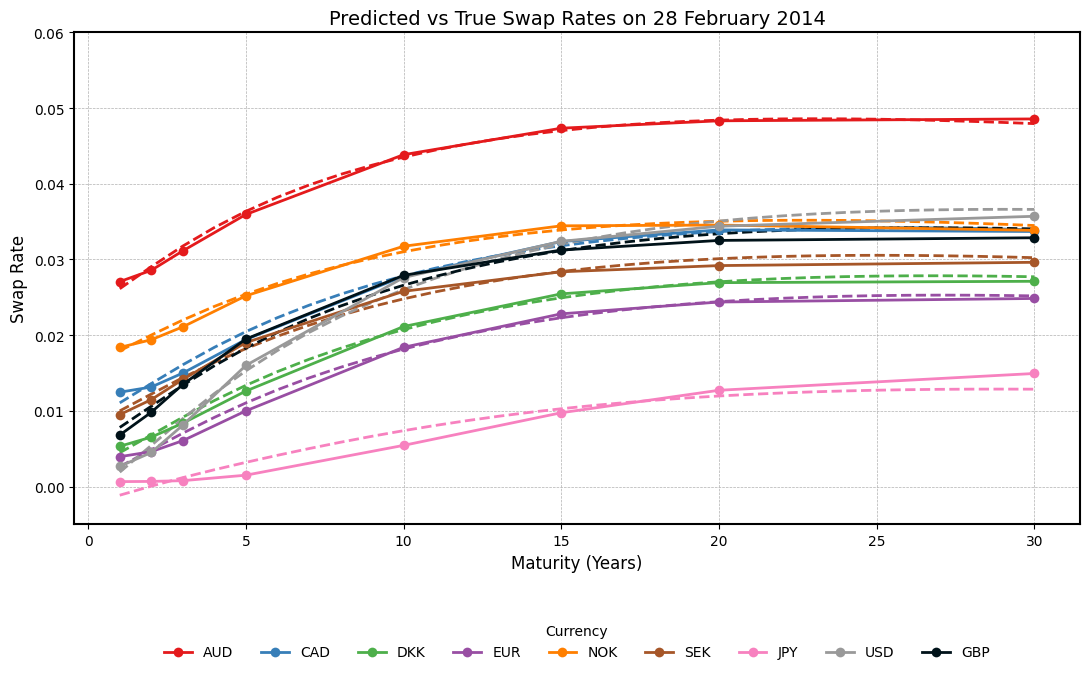

In [ ]:
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(selected_data)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)  

selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

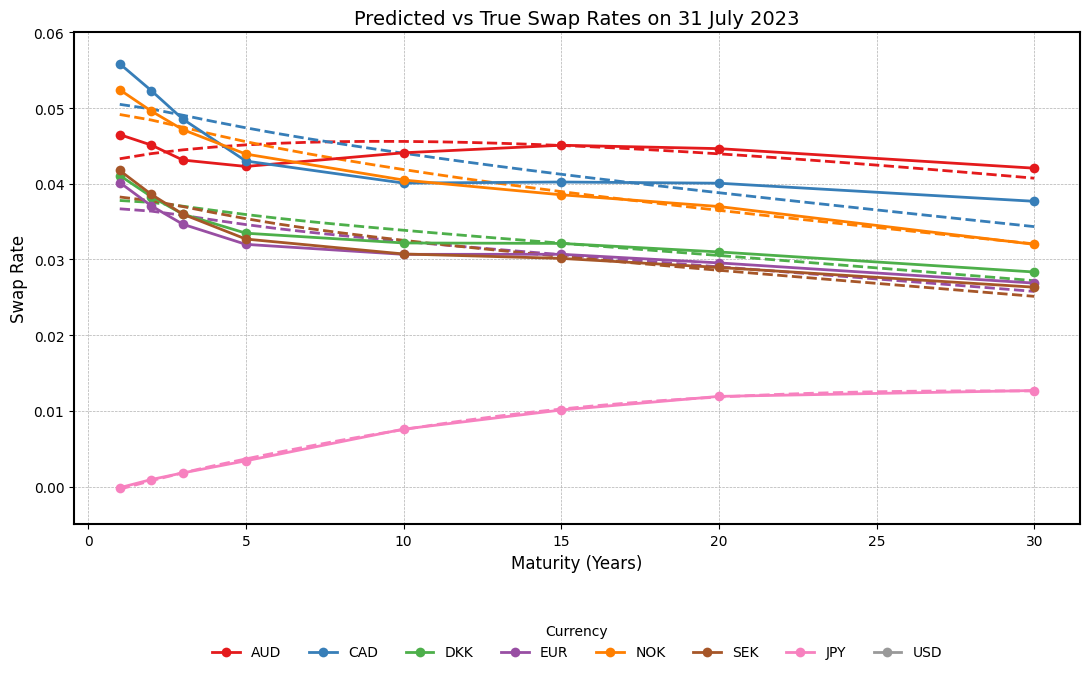

In [ ]:
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(filtered_data_tensor)
predicted_swaps = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities) 

plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     
        line.set_markerfacecolor(line.get_color()) 
        line.set_markeredgewidth(0)                

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [ ]:
data_tensor = torch.cat((train_tensor, val_tensor), dim=0)
data_currencies_np = np.concatenate((train_currencies_np, val_currencies_np))

def leave_one_currency_out_cv(model, data_tensor, data_currencies_np):
    unique_currencies = np.unique(data_currencies_np)
    results = []
    
    for left_out_currency in unique_currencies:
        print(f"Leaving out: {left_out_currency}")
        
        train_mask = data_currencies_np != left_out_currency
        test_mask = data_currencies_np == left_out_currency
        
        train_data = data_tensor[train_mask]
        test_data = data_tensor[test_mask]
        
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 50))
        criterion = torch.nn.MSELoss()
        
        for epoch in range(5000): 
            zero_coupon_rates_pred, _, maturities = model(train_data)
            swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)
            loss = criterion(swap_rates_pred[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        model.eval()
        zero_coupon_rates_pred_test, _, maturities = model(test_data)
        swap_rates_pred_test = zero_coupon_to_swap_rates(zero_coupon_rates_pred_test, maturities)
        rmse_unseen = torch.sqrt(criterion(swap_rates_pred_test[:, [0, 1, 2, 4, 9, 14, 19, 29]], test_data)).item() * 10_000  
        
        zero_coupon_rates_pred_train, _, maturities = model(train_data)
        swap_rates_pred_train = zero_coupon_to_swap_rates(zero_coupon_rates_pred_train, maturities)
        rmse_seen = torch.sqrt(criterion(swap_rates_pred_train[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)).item() * 10_000 
        results.append({"Currency Left Out": left_out_currency, "RMSE Unseen (bps)": rmse_unseen, "RMSE Seen (bps)": rmse_seen})
    
    return results

cv_results = leave_one_currency_out_cv(model, data_tensor, data_currencies_np)

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))

In [ ]:
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
    swap_rates_selected = swap_rates[:, selected_indices]

    mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
    rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000
    return rmse_per_maturity.cpu().detach().numpy()

rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

,Maturity (Years),Train RMSE (bps),Validation RMSE (bps),Test RMSE (bps)
0,1,14.360951,12.408824,41.349564
1,2,4.132998,3.348857,11.006241
2,3,7.606911,6.686591,11.779936
3,5,11.239081,10.055698,22.594780
4,10,8.411539,8.050260,11.758452
5,15,4.797512,4.492775,5.003473
6,20,5.171287,4.855010,10.751735
7,30,10.778947,10.009497,18.705442


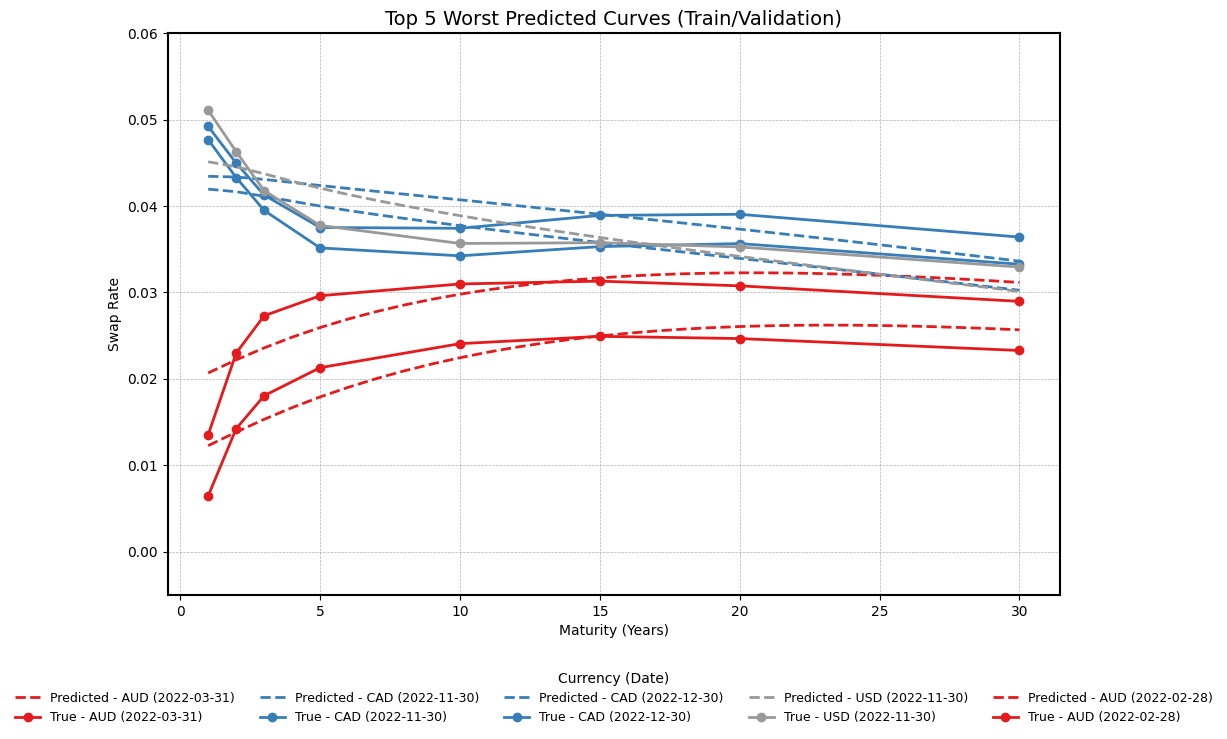

In [ ]:
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(train_val_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    #plt.text(
    #    x=selected_maturities[-1] + 0.4,
    #    y=true_curve[-1],
    #    s=label,
     #   fontsize=9,
    #    color=color,
    #    verticalalignment='center'
    #)

plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

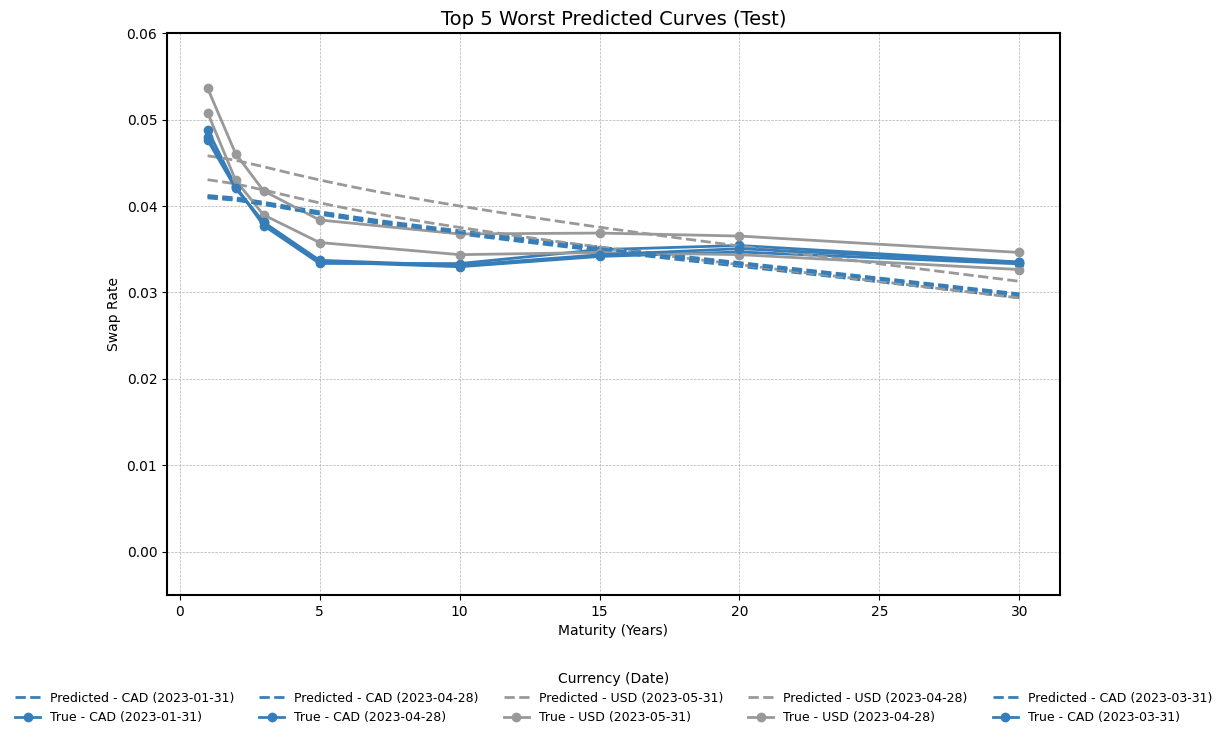

In [ ]:
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(test_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

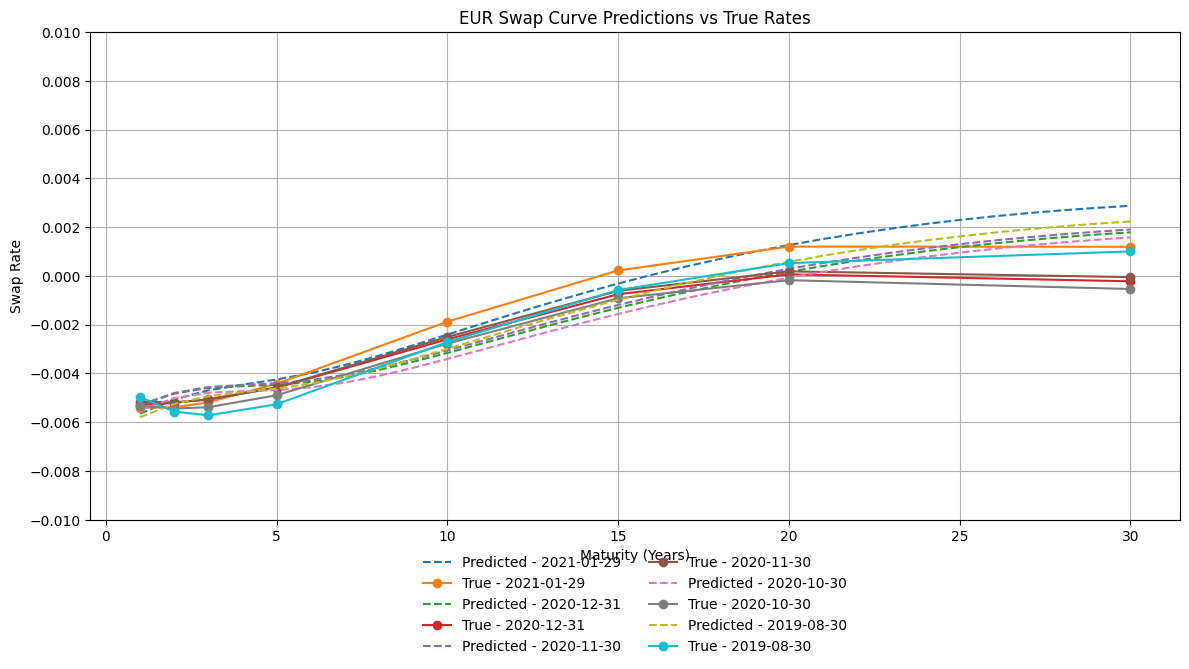

In [ ]:
def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    zero_coupon_rates = zero_coupon_rates[:, 1:] 
    maturities = torch.arange(1, 31, dtype=torch.float32, device=zero_coupon_rates.device).unsqueeze(0)

    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums

    return swap_rates, discount_factors

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

target_dates = pd.to_datetime([
    "2019-08-30", "2020-10-30", "2021-01-29", "2020-12-31", "2020-11-30"
])
target_currency = "EUR"

filtered_df = data_full[
    (data_full["Currency"] == target_currency) &
    (data_full["Date"].isin(target_dates))
].copy()

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

x_tensor = torch.tensor(filtered_df.iloc[:, 2:].values, dtype=torch.float32)
dates = filtered_df["Date"].dt.strftime("%Y-%m-%d").values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
swap_rates_pred, discount_factors_2 = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)

plt.figure(figsize=(12, 7))
for i, date in enumerate(dates):
    true_curve = x_tensor[i].numpy()
    pred_curve = swap_rates_pred[i].detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", label=f"Predicted - {date}")
    plt.plot(selected_maturities, true_curve, marker="o", label=f"True - {date}")

plt.title("EUR Swap Curve Predictions vs True Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.grid(True)
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.002))
plt.ylim(-0.01, 0.01)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

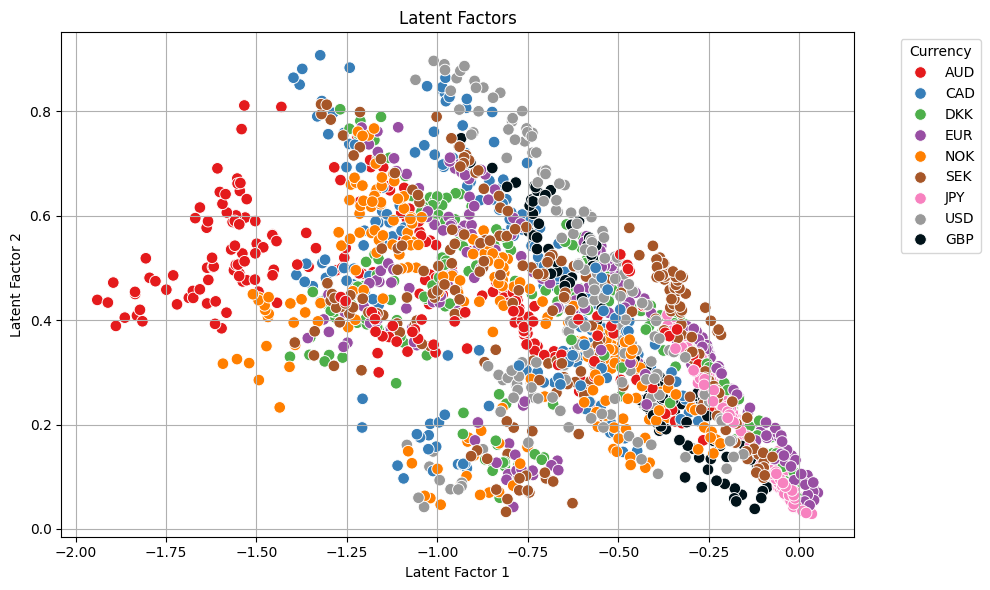

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

#model.load_state_dict(torch.load("best_fiae2_model_final.pt"))
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(data_tensor)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=latent_df,
    x="Latent_1", y="Latent_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    s=70
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Currency")
plt.tight_layout()
plt.show()

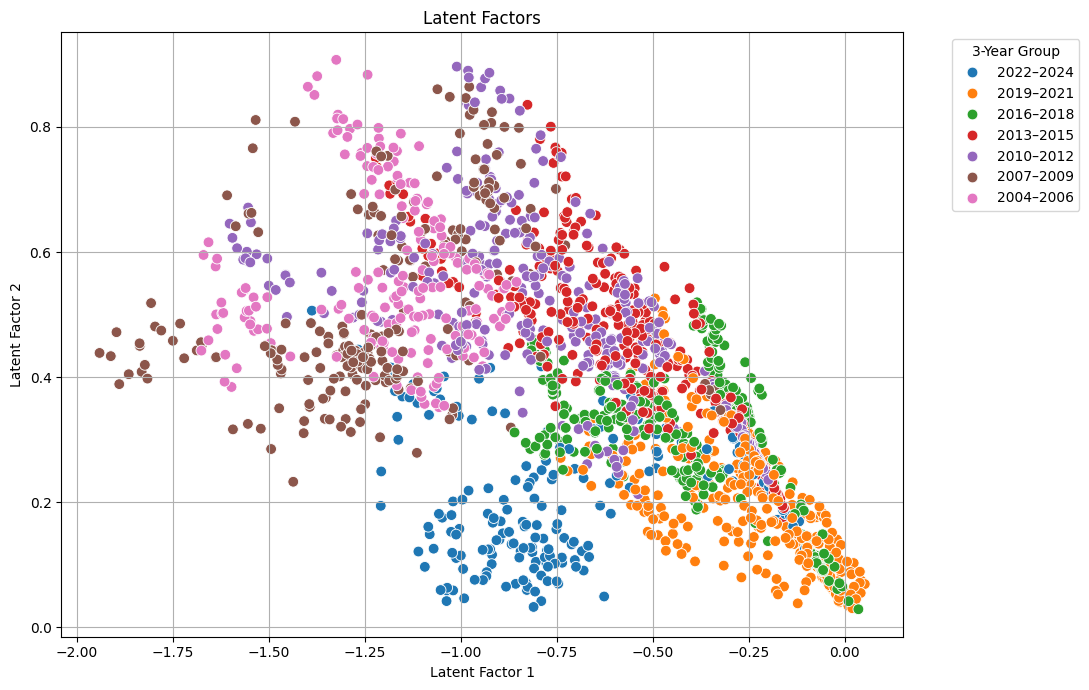

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
currencies = data_filtered["Currency"].values
year_groups = data_filtered["YearGroup"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(data_tensor)

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "YearGroup": year_groups
})

plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=latent_df, x="Latent_1", y="Latent_2",
    hue="YearGroup", palette="tab10", s=60
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="3-Year Group")
plt.tight_layout()
plt.show()

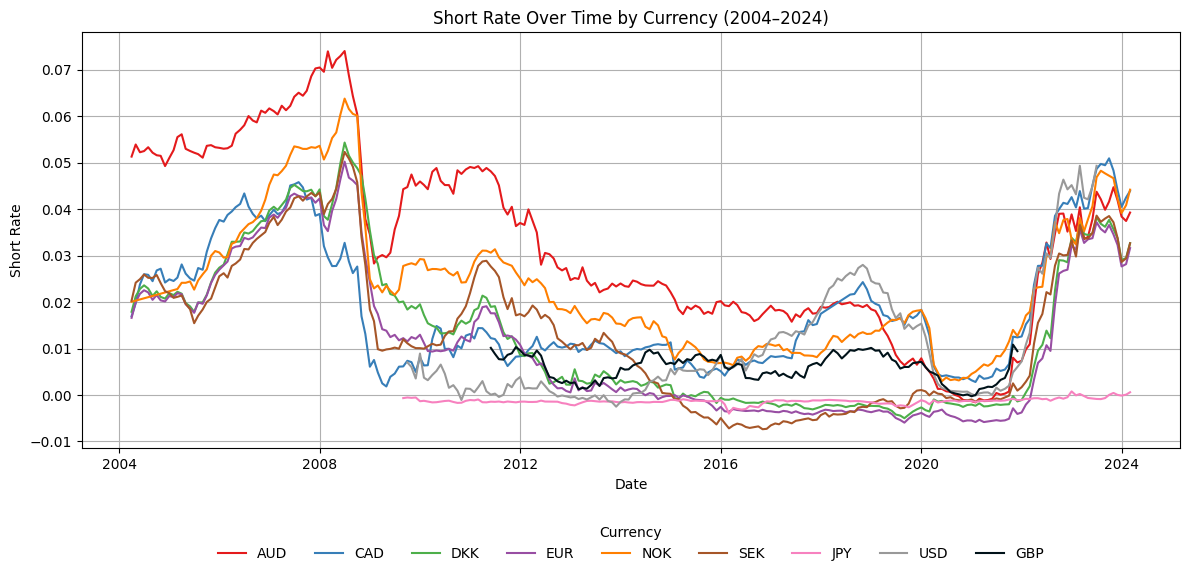

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

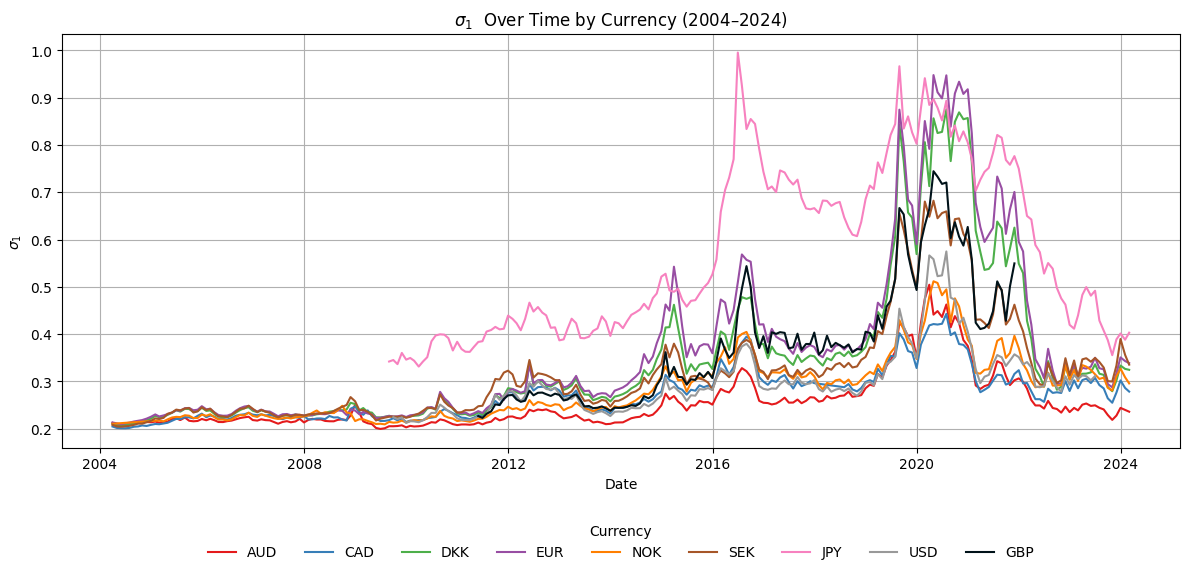

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

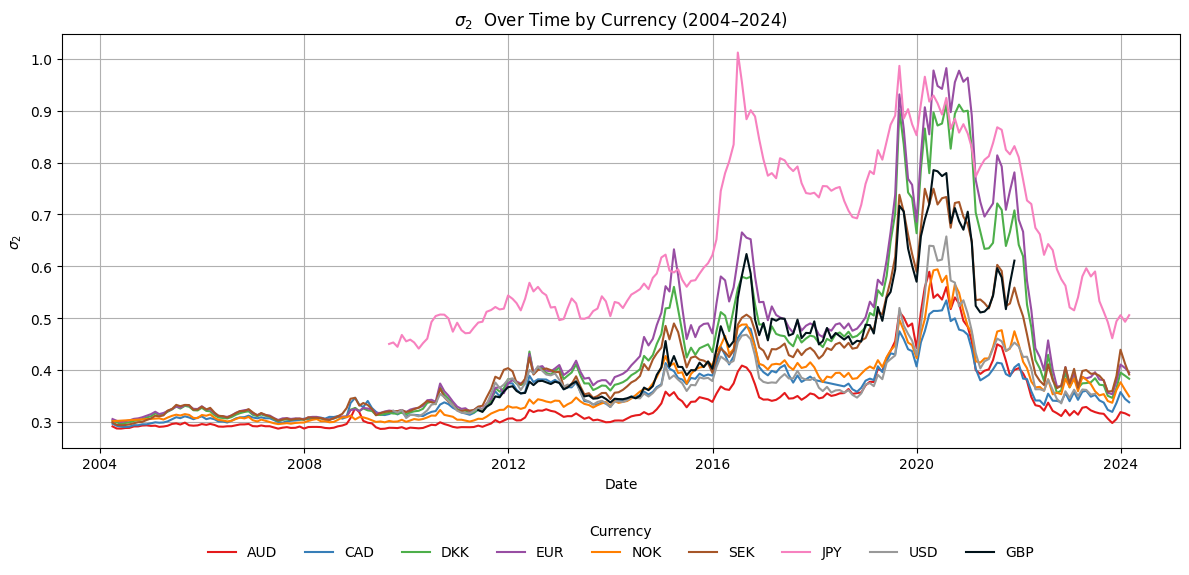

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

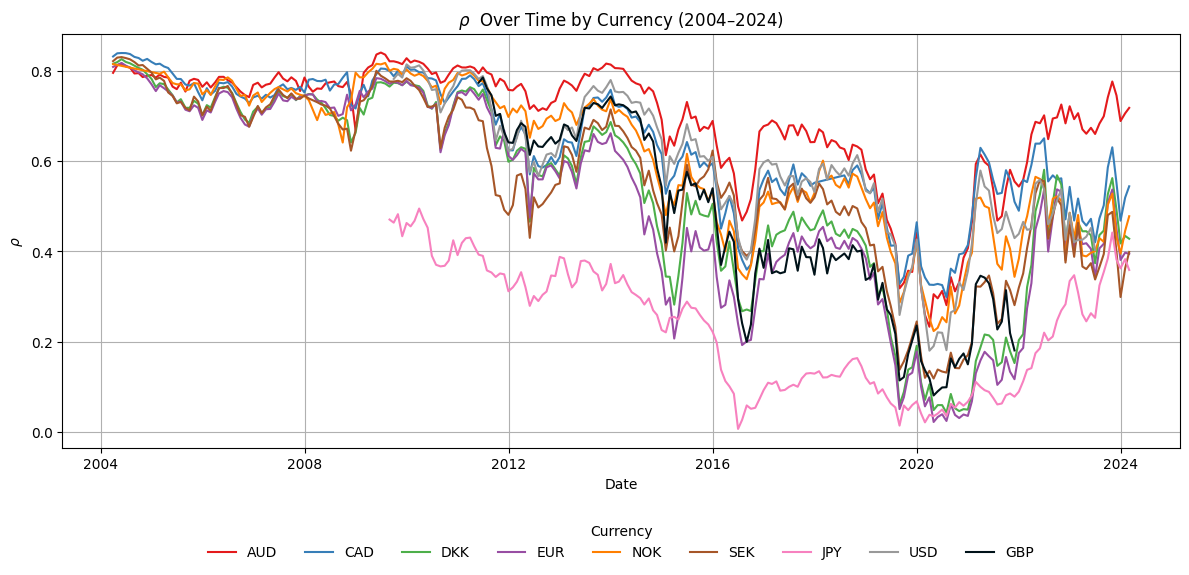

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
rho = rho1[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

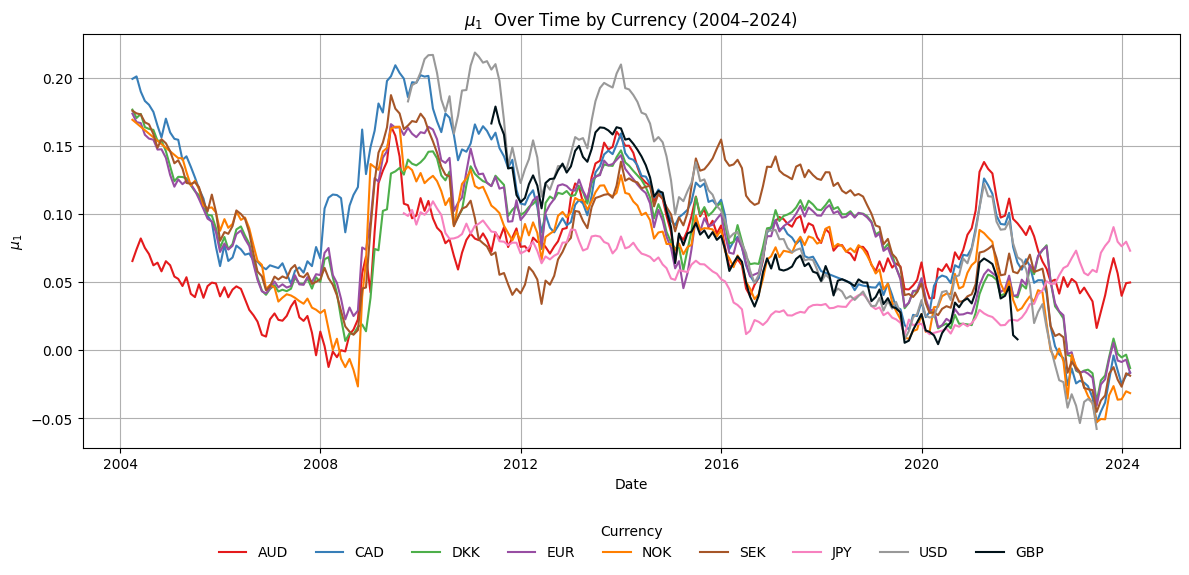

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

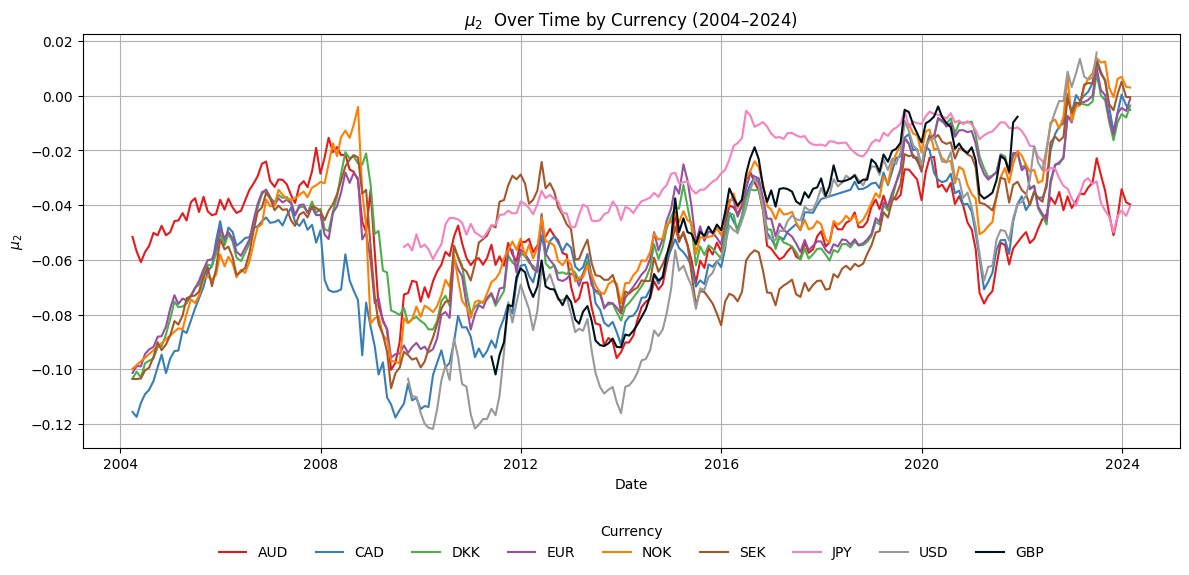

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

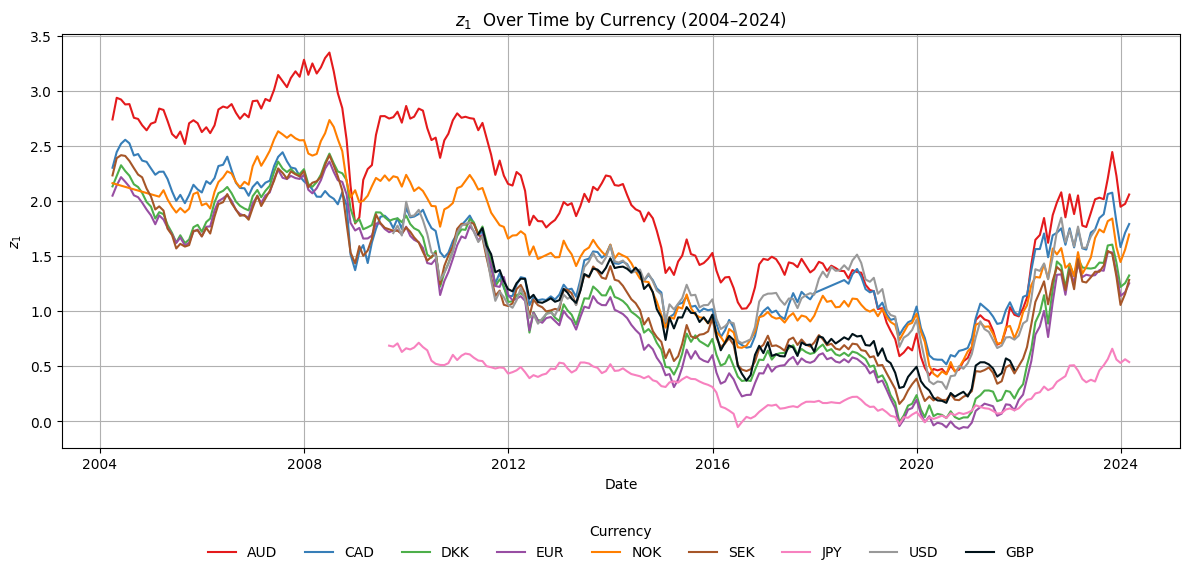

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

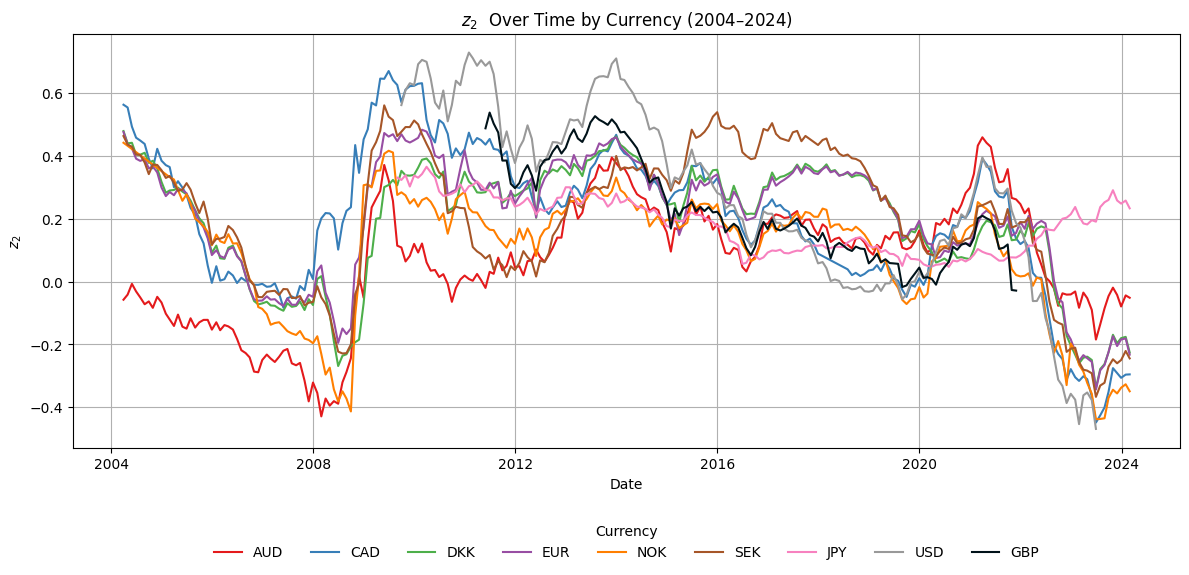

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()